In [1]:
import json
import pandas as pd
import os
from pathlib import Path
import sys
import numpy as np

sys.path.append("../")

from config import DATA_DIR
from graph_types.graph import Graph

graph_name = "amazon"

In [2]:
# graph = Graph.load(graph_name)

In [12]:
logs_dir = DATA_DIR / f"experiments/{graph_name}/subgraph_explorer"
json_files = sorted([f for f in logs_dir.glob("*.json")], key=lambda x: x.stat().st_ctime)

data = []

for json_file in json_files:
    with open(json_file, "r") as f:
        log_data = json.load(f)

    # Extract key information from each log entry
    record = {
        "file_id": int(json_file.stem),
        "question": log_data.get("question", ""),
        "all_nodes": log_data.get("all_nodes", []),
        "conversations_as_string": log_data.get("conversations_as_string", ""),
        "starting_nodes_indices": log_data.get("starting_nodes_indices", []),
        "agent_answer_indices": log_data.get("agent_answer_indices", []),
        "answer_indices": log_data.get("answer_indices", []),
    }

    data.append(record)

df = pd.DataFrame(data).reset_index(drop=True)# .sort_values(by="file_id").reset_index(drop=True)

df["recall@all"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"])))
    / len(set(row["answer_indices"])),
    axis=1,
)
df["hit@1"] = df.apply(
    lambda row: (
        row["agent_answer_indices"][0] in row["answer_indices"]
        if row["agent_answer_indices"]
        else False
    ),
    axis=1,
)
df["hit@5"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:5])))
    > 0,
    axis=1,
)
df["hit@10"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:10])))
    > 0,
    axis=1,
)
df["recall@20"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:20])))
    / len(set(row["answer_indices"])),
    axis=1,
)

[
    ("n", len(df)),
    ("Hit@1", float(round(df["hit@1"].mean(), 3))),
    ("Hit@5", float(round(df["hit@5"].mean(), 3))),
    ("Recall@20", float(round(df["recall@20"].mean(), 3))),
    ("Recall@all", float(round(df["recall@all"].mean(), 3))),
]

[('n', 2),
 ('Hit@1', 1.0),
 ('Hit@5', 1.0),
 ('Recall@20', 0.514),
 ('Recall@all', 0.514)]

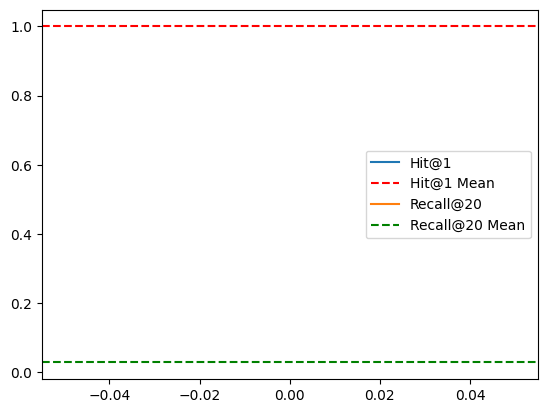

In [4]:
import matplotlib.pyplot as plt
plt.plot([df['hit@1'].iloc[:i].mean() for i in range(1, len(df) + 1)], label='Hit@1')
plt.axhline(y=df['hit@1'].mean(), color='r', linestyle='--', label='Hit@1 Mean')
plt.plot([df['recall@20'].iloc[:i].mean() for i in range(1, len(df) + 1)], label='Recall@20')
plt.axhline(y=df['recall@20'].mean(), color='g', linestyle='--', label='Recall@20 Mean')
plt.legend()


### When it went wrong, what happened?

In [5]:
df_wrong = df[df['recall@all'] == 0]

df_wrong['starting_node_names'] = df_wrong['starting_nodes_indices'].apply(
    lambda x: [graph.get_node_by_index(idx).name for idx in x]
)
df_wrong['answer_node_names'] = df_wrong['answer_indices'].apply(
    lambda x: [graph.get_node_by_index(idx).name for idx in x]
)   
df_wrong['agent_answer_node_names'] = df_wrong['agent_answer_indices'].apply(
    lambda x: [graph.get_node_by_index(idx).name for idx in x]
)   

In [6]:
for _, row in df_wrong.iterrows():
    print("Question:", row["question"], 'index', row["file_id"])
    print("Starting node names:", row["starting_node_names"])
    print("Starting nodes indices:", row["starting_nodes_indices"])
    print("Answer node names:", row["answer_node_names"])
    print("Answer indices:", row["answer_indices"])
    print("Agent answer node names:", row["agent_answer_node_names"])
    print()

In [7]:
graph.get_node_by_index(128417)

NameError: name 'graph' is not defined

In [ ]:
graph.get_khop_subgraph(graph.get_node_by_index(37182), 2).nodes_df

,id,mag_id,Rank,DisplayName,LastKnownAffiliationId,PaperCount,CitationCount,type,new_id,Level,...,ConferenceSeriesId.1,Location,StartDate,EndDate,ConferenceInstancesPaperCount,ConferenceInstanceCitationCount,title,abstract,index,name
63,65,1503591,17747.0,Priyamvada Jadaun,86519309.0,17.0,61.0,author,63,NaN,...,NaN,None,None,None,NaN,NaN,None,None,63,Priyamvada Jadaun
186,189,4129598,12713.0,Harry L. Swinney,86519309.0,430.0,21604.0,author,186,NaN,...,NaN,None,None,None,NaN,NaN,None,None,186,Harry L. Swinney
212,215,4837528,11418.0,Rodney S. Ruoff,48566637.0,659.0,124985.0,author,212,NaN,...,NaN,None,None,None,NaN,NaN,None,None,212,Rodney S. Ruoff
289,292,7433618,18317.0,Solomon Manukure,86519309.0,11.0,48.0,author,289,NaN,...,NaN,None,None,None,NaN,NaN,None,None,289,Solomon Manukure
329,332,8253814,14510.0,Roger T. Bonnecaze,86519309.0,167.0,4240.0,author,329,NaN,...,NaN,None,None,None,NaN,NaN,None,None,329,Roger T. Bonnecaze
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1863909,719026,2962876139,NaN,None,NaN,NaN,NaN,paper,1863909,NaN,...,-1.0,-1,-1,-1,-1.0,-1.0,The MASSIVE Survey. II. Stellar Population Tre...,We examine stellar population gradients in ?10...,1863909,The MASSIVE Survey. II. Stellar Population Tre...
1865184,721632,2963351266,NaN,None,NaN,NaN,NaN,paper,1865184,NaN,...,-1.0,-1,-1,-1,-1.0,-1.0,A simultaneous search for High-z LAEs and LBGs...,We have undertaken a comprehensive search for ...,1865184,A simultaneous search for High-z LAEs and LBGs...
1866634,724663,2963923661,NaN,None,NaN,NaN,NaN,paper,1866634,NaN,...,-1.0,-1,-1,-1,-1.0,-1.0,J-PLUS: analysis of the intracluster light in ...,Y. J-T. also acknowledges financial support fr...,1866634,J-PLUS: analysis of the intracluster light in ...
1868541,728033,2967384074,NaN,None,NaN,NaN,NaN,paper,1868541,NaN,...,-1.0,-1,-1,-1,-1.0,-1.0,The first maps of κd - the dust mass absorptio...,"The dust mass absorption coefficient, κd is th...",1868541,The first maps of κd - the dust mass absorptio...


In [ ]:
graph.get_node_by_index(96612)

AuthorNode(name=M. Schneiter, index=96612, type=author)